In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from transformer_pipeline import drop_rows, get_features_transformer
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from metrics import *
from sklearn.cluster import DBSCAN
import sklearn
import warnings
warnings.filterwarnings("ignore")

In [2]:
from dimensionality_reduction_and_explanation_tools import *
dim_red_funs = [get_nmf_plots,get_pca_plots,get_tsne_plots]

In [3]:
df = pd.read_csv("data/movie_statistic_dataset.csv")
df = drop_rows(df)

# Hierarchcal clustering

In [4]:
AG_transformer = make_pipeline(get_features_transformer(PowerTransformer(method="box-cox"),
                                          PowerTransformer(method="box-cox"),
                                          StandardScaler(),
                                          StandardScaler()), MinMaxScaler())
AG_X = AG_transformer.fit_transform(df)

In [5]:
model = AgglomerativeClustering()

parameters = {
    "n_clusters": [None],
    "linkage": ['ward', 'complete', 'average', 'single'],
    "distance_threshold": uniform(5,40)}

score = {
    "silhouette_score": silhouette,
    "calinski_harabasz_score": calinski_harabasz,
    "davies_bouldin_score": davies_bouldin}

In [6]:
tester = RandomizedSearchCV(estimator=model,
                            param_distributions= parameters,
                            random_state=14, 
                            scoring=score,
                            refit='silhouette_score',
                            n_iter=100,
                            cv=2) 

In [7]:
random_result = tester.fit(AG_X)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))


Best: 0.280132 using {'distance_threshold': 5.321877941192716, 'linkage': 'ward', 'n_clusters': None}


In [8]:
model = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=10)
y = model.fit_predict(AG_X)
model.n_clusters_

29

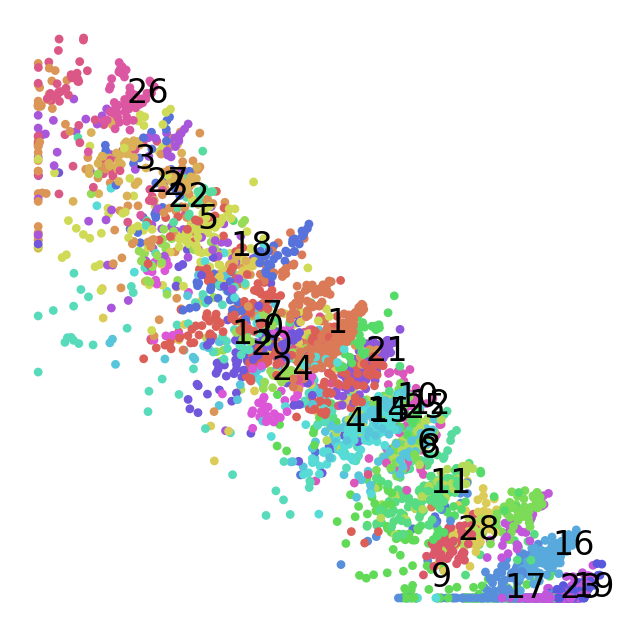

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [19] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


[scatterd] >INFO> Create scatterplot


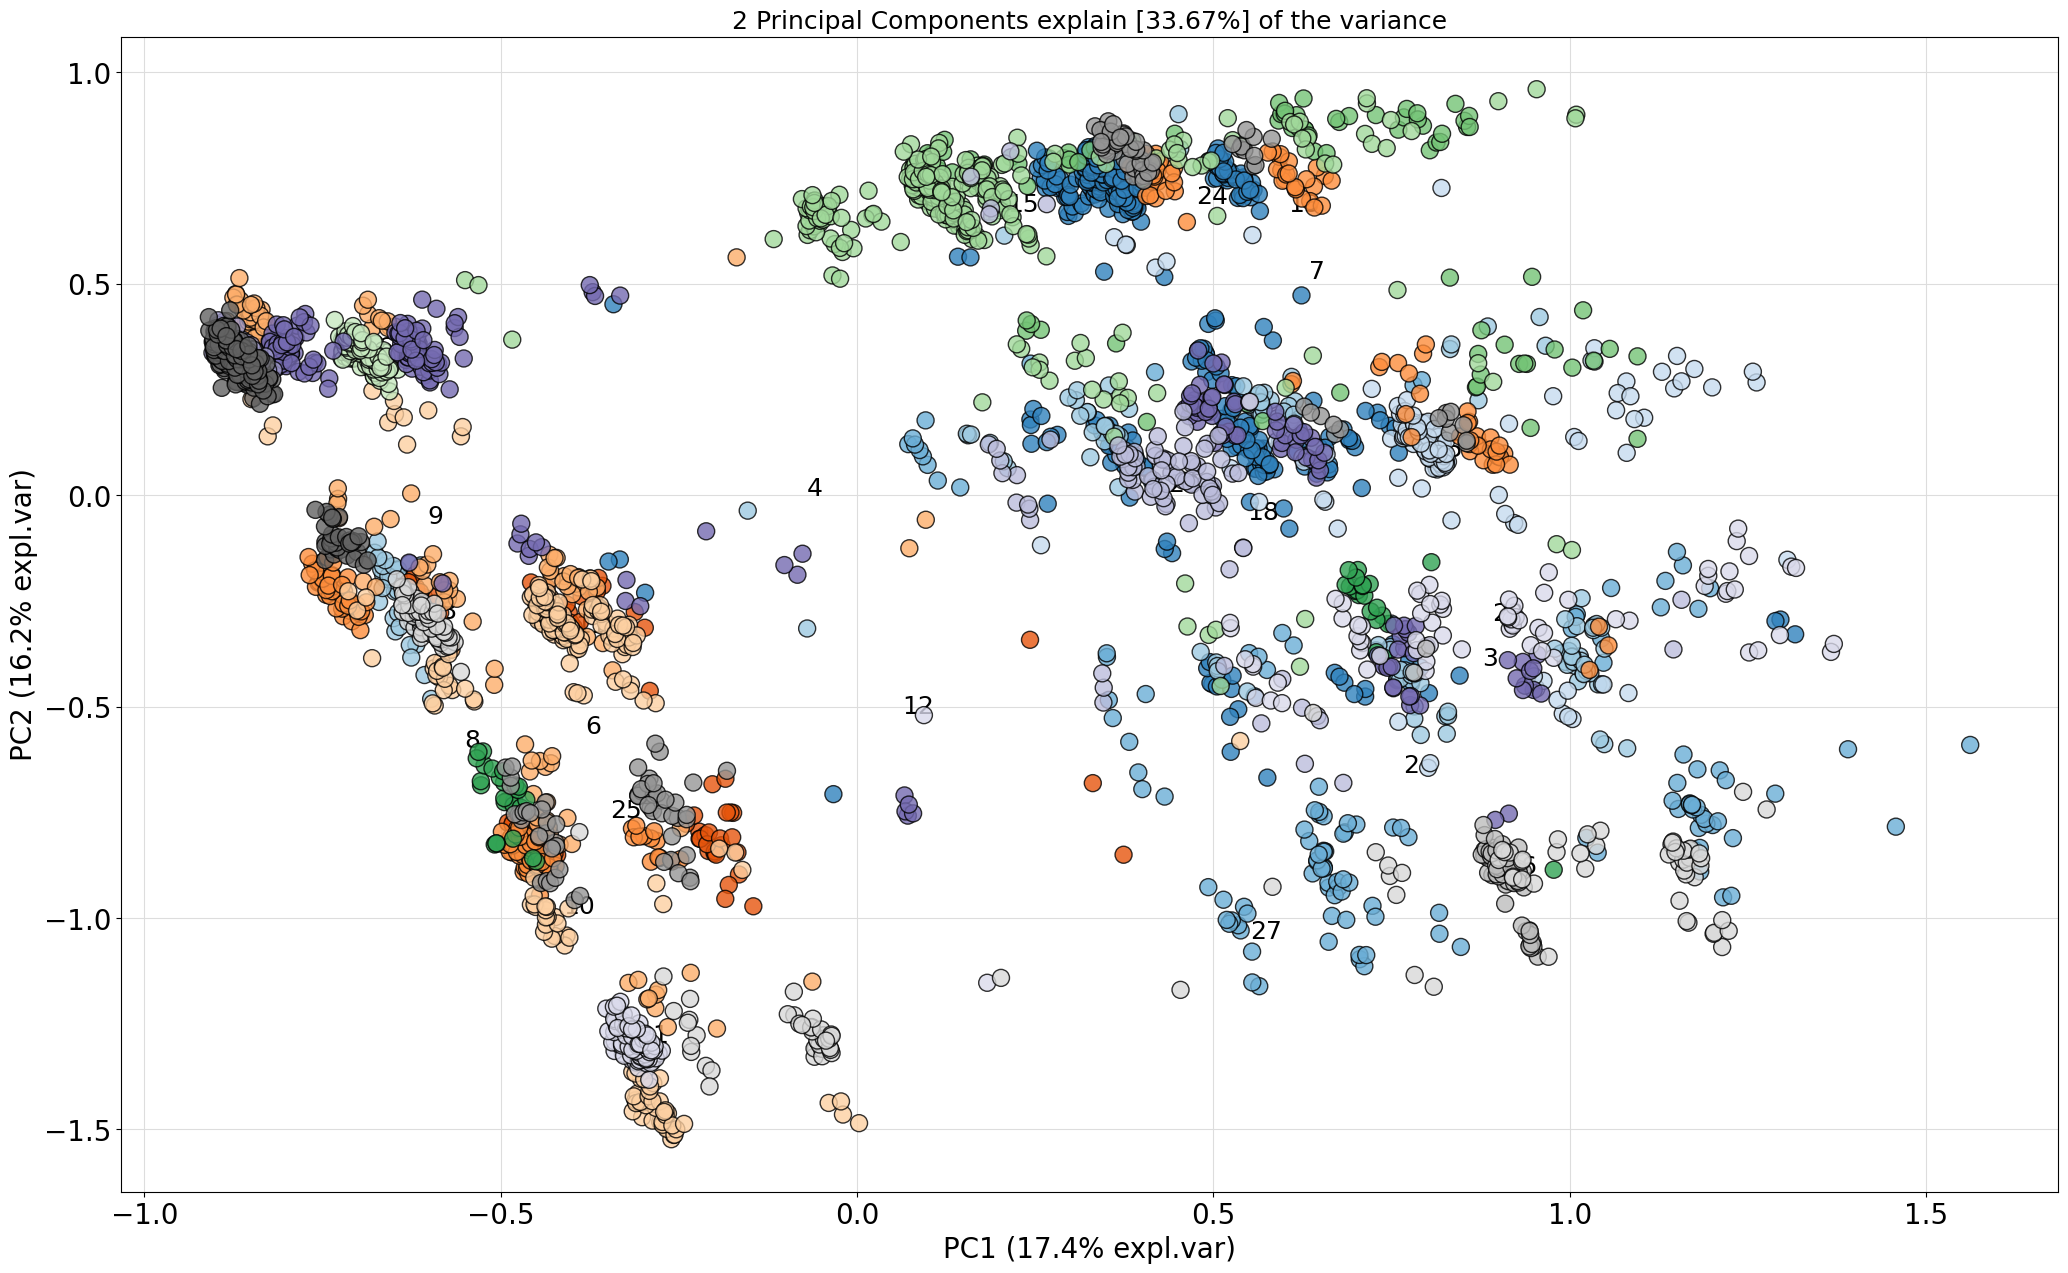

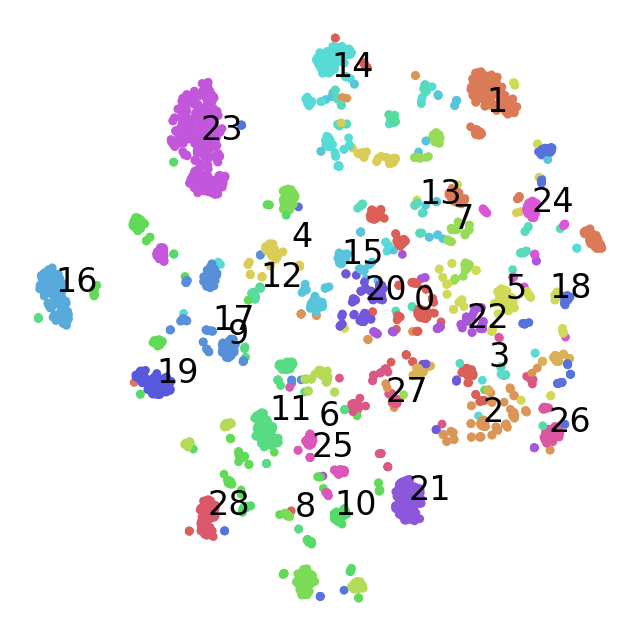

In [9]:
for fun in dim_red_funs:
    fun(AG_X,y)

# DBSCAN

In [10]:
DB_transformer = make_pipeline(get_features_transformer(PowerTransformer(method="box-cox"),
                                          PowerTransformer(method="box-cox"),
                                          StandardScaler(),
                                          StandardScaler()))
DB_X = DB_transformer.fit_transform(df)
DB_X.shape

(3490, 19)

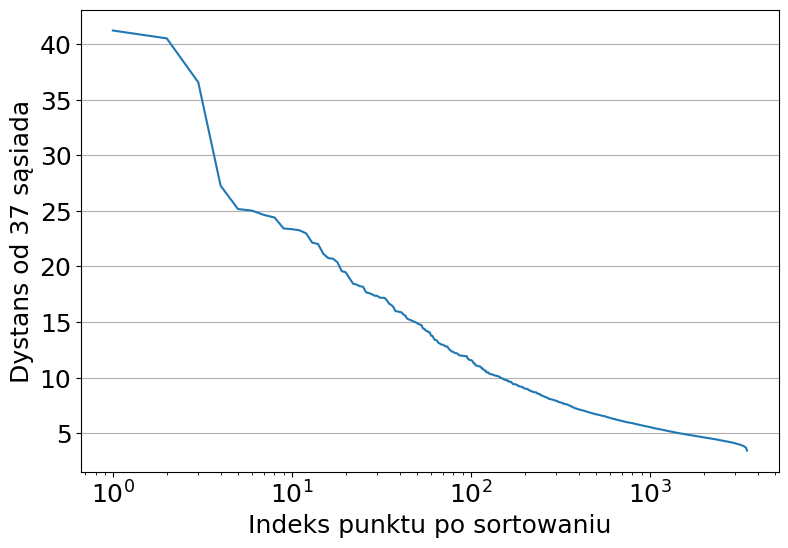

In [11]:
minPts = 38
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(DB_X)
distances, indices = nbrs.kneighbors(DB_X)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od 37 sąsiada')
ax1.plot(list(range(1,DB_X.shape[0]+1)), distanceDec)
plt.xscale('log')
plt.grid(axis='y')

plt.show()


In [12]:
#SOMETHING IS WRONG BUT IT IS THE END FOR TODAY
model = DBSCAN()
parameters = {
    "eps": [i for i in range(20,30)], #it suppose to be points with great loss on the plot but they give nan :)
    "min_samples": [minPts],
    "algorithm":['auto', 'ball_tree', 'kd_tree', 'brute']}

score = {
    "silhouette_score": silhouette,
    "calinski_harabasz_score": calinski_harabasz,
    "davies_bouldin_score": davies_bouldin}

In [13]:
tester = RandomizedSearchCV(estimator=model,
                            param_distributions= parameters,
                            random_state=14, 
                            scoring=score,
                            refit='silhouette_score',
                            n_iter=100,
                            # cv=5
                            ) 

In [14]:
random_result = tester.fit(DB_X)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: nan using {'min_samples': 38, 'eps': 20, 'algorithm': 'auto'}


In [15]:
model = tester.best_estimator_
y = model.fit_predict(DB_X)

how TF eps is higher than top value in uniform?


[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [19] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[14]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


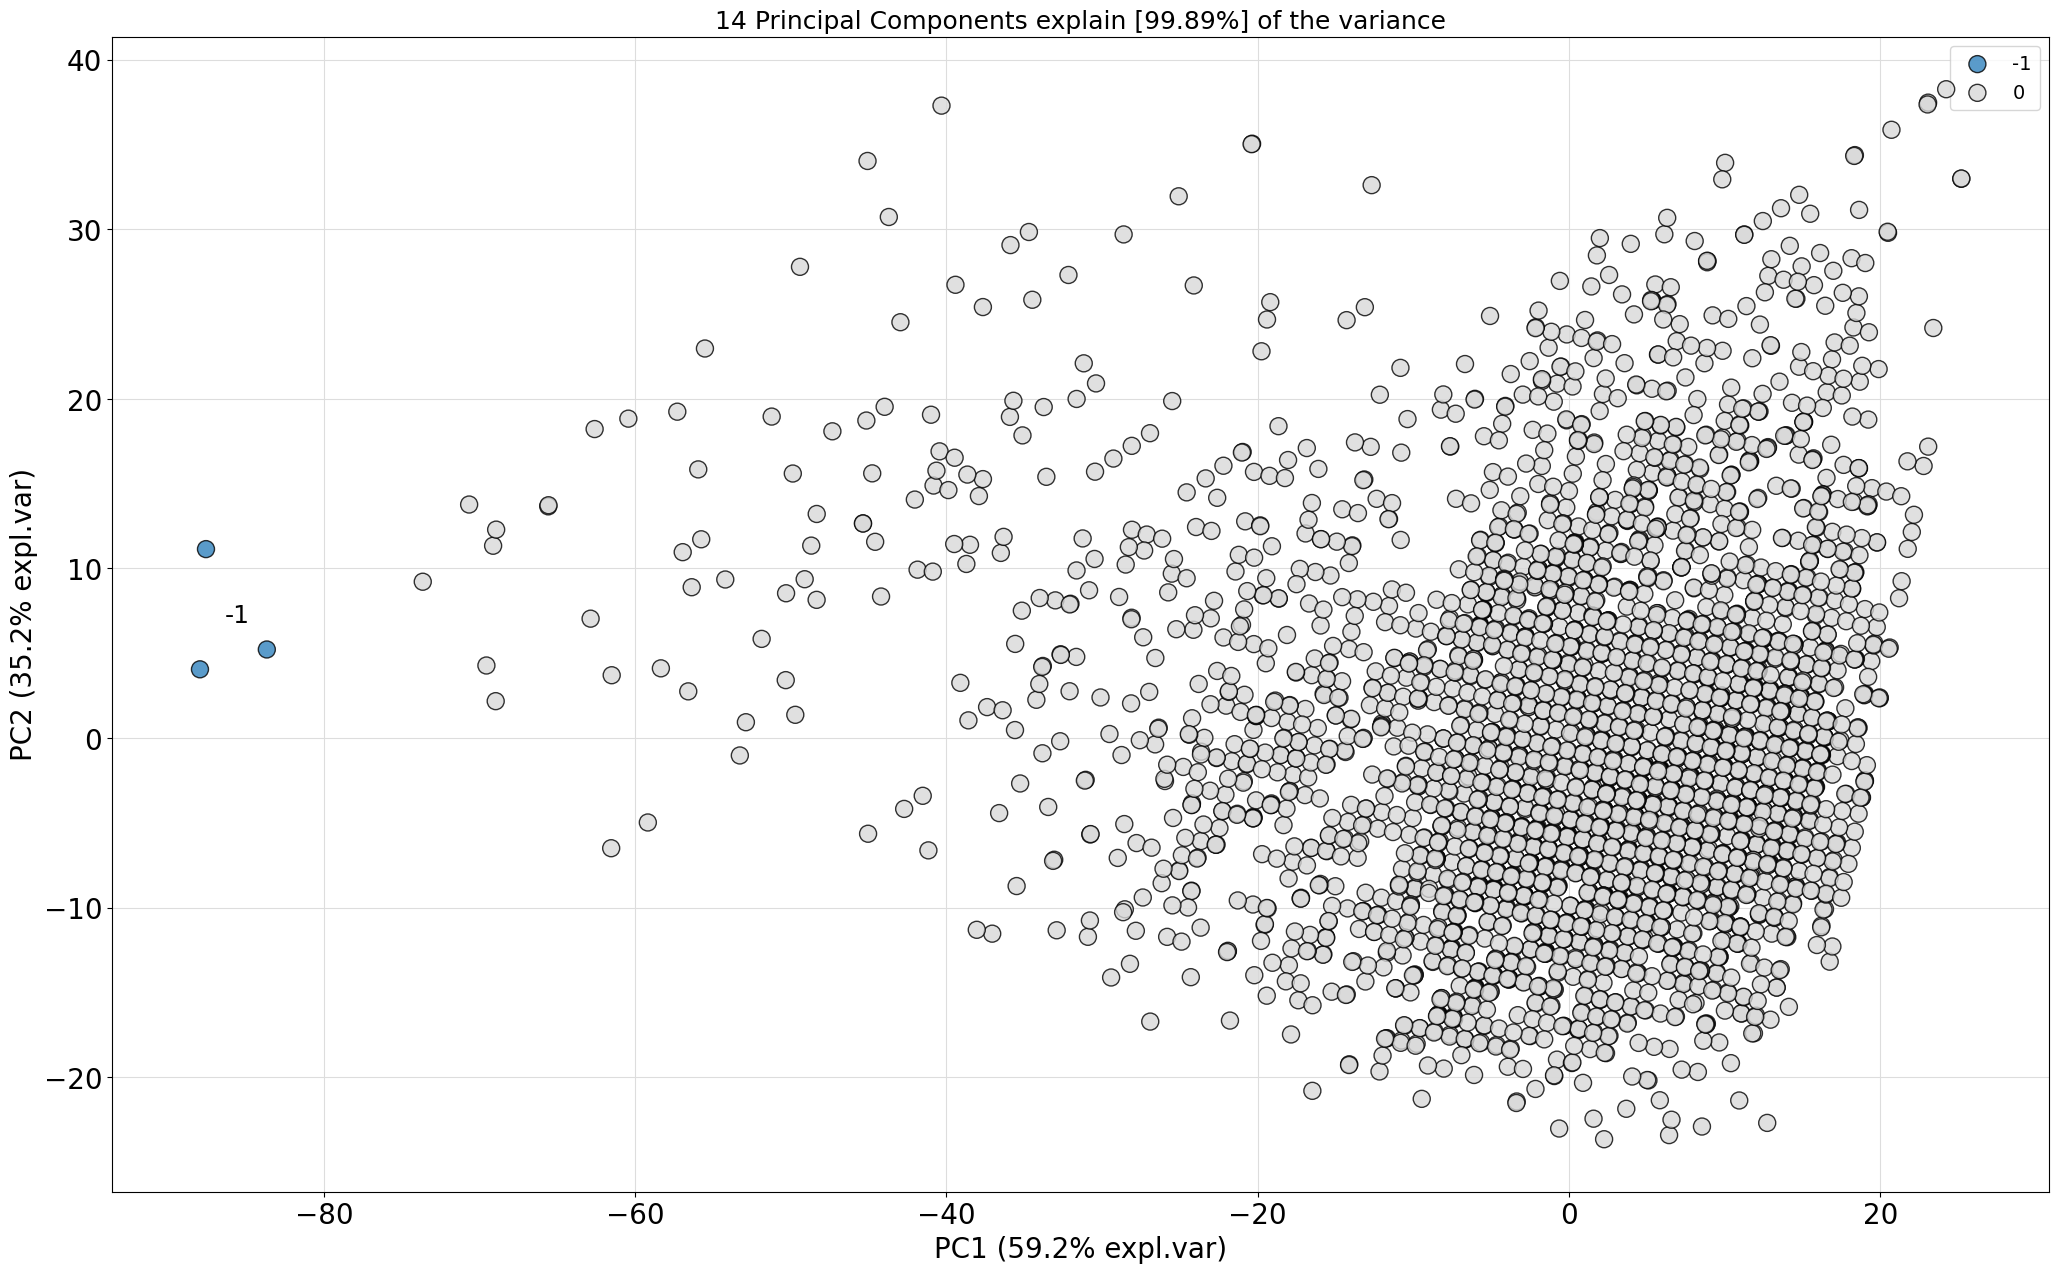

[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values


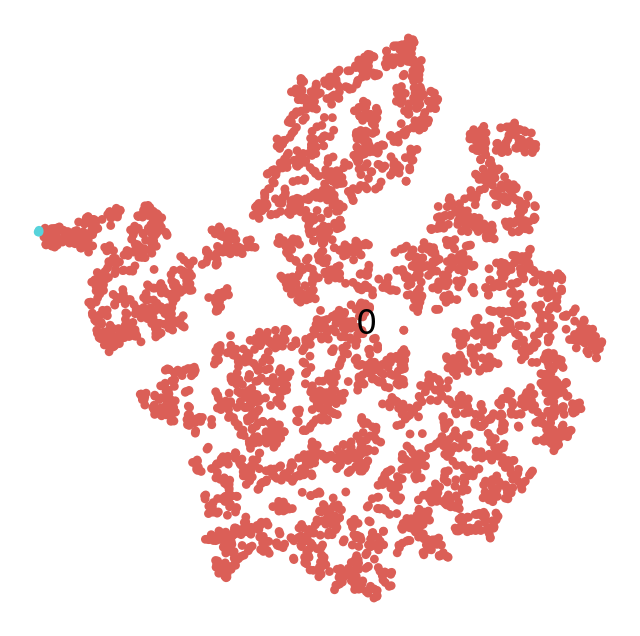

In [61]:
for fun in [get_pca_plots,get_tsne_plots]:
    fun(DB_X,y)

# HDBSCAN

I JUST PREPARED THE TEMPLATE

In [ ]:
HDB_transformer = make_pipeline(get_features_transformer())
HDB_X = HDB_transformer.fit_transform(df)

In [ ]:
model = AgglomerativeClustering()

parameters = {
    "n_clusters": [None],
    "linkage": ['ward', 'complete', 'average', 'single'],
    "distance_threshold": uniform(5,40)}

score = {
    "silhouette_score": silhouette,
    "calinski_harabasz_score": calinski_harabasz,
    "davies_bouldin_score": davies_bouldin}

In [ ]:
tester = RandomizedSearchCV(estimator=model,
                            param_distributions= parameters,
                            random_state=14, 
                            scoring=score,
                            refit='silhouette_score',
                            n_iter=100,
                            cv=5) 

In [ ]:
random_result = tester.fit(AG_X)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))